# Linear SVC

### Primal Formulation

$$
\begin{align}
&\min_{\mathbf{w}, b} && \frac{1}{2}\mathbf{w}^{T}\mathbf{w} + C \sum_{i=1}^{m}\xi_{i}\\
&\text{subj. to} && y_{i}(\mathbf{w}^{T}\mathbf{x}_{i} + b) \ge 1 - \xi_{i}, \quad \xi_{i} \ge 0
\end{align}
$$

Make the substitution $\xi_{i} = \max\Big(0, 1 - y_{i}(\mathbf{w}^{T}\mathbf{x}_{i} + b)\Big)$.  Note that this choice of $\xi_{i}$ satisfies the constraints of the primal problem.  The new primal problem, which is unconstrained, becomes: 

$$
\begin{align}
&\min_{\mathbf{w}, b} && \frac{1}{2}\mathbf{w}^{T}\mathbf{w} + C \sum_{i=1}^{m}\max\Big(0, 1 - y_{i}(\mathbf{w}^{T}\mathbf{x}_{i} + b)\Big)
\end{align}
$$

where the first term seeks to create a wide margin and second term is the hinge loss which will be positive for misclassified instances.  Setting C very large results in a hard margin classifier.

In [1]:
import numpy as np
import numpy.linalg as LA
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Load the data
iris = datasets.load_iris()

#convert to dataframe
df = pd.DataFrame(iris.data, columns = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width'])
df.insert(4,'Target',iris.target)
# target = [0,1,2] corresponds to Setosa, Versicolour, and Virginica, resp.
df.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
#Extract features and labels
X =  df[['Petal Length', 'Petal Width']].values
y = (df[['Target']].values == 2).astype(np.float64).squeeze()

#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Scale the data
scalerX = StandardScaler().fit(X)
X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)

## sklearn Linear SVC

In [4]:
#sklearn linear SVC
c = 1
lsvc = LinearSVC(C=c, loss='hinge')
lsvc.fit(X_train_scaled,y_train)
coefs = lsvc.coef_.flatten()
intercept = lsvc.intercept_
theta_lsvc_sklearn = np.concatenate((coefs, intercept), axis=0)
print("Linear SVC coefficients (sklearn):")
print(theta_lsvc_sklearn)

Linear SVC coefficients (sklearn):
[ 1.30870506  2.24455751 -2.07046507]


In [5]:
#hinge loss
def hinge_loss(theta,X,y):
    loss, grad = 0,0
    for (x_,y_) in zip(X,y):
        v = y_*np.dot(x_,theta)
        loss += max(0,1-v)
        grad += 0 if v > 1 else -y_*x_
    return loss,grad

## scratch Linear SVC

In [6]:
y_train_lsvc = (np.copy(y_train)).reshape(-1,1)
y_train_lsvc[y_train == 0] = -1

X_aug = np.concatenate( (X_train_scaled, np.ones((len(X_train_scaled),1))), axis=1)

#solve via GD
epsilon = 1e-7
delta = np.inf
alpha = 1e-3
theta0 = np.zeros((X_aug.shape[1]))
theta = []
theta.append(theta0)
J = []
J.append(np.inf)
k = 0

while delta > epsilon:
    #compute penalty and gradient of penalty
    loss, grad = hinge_loss(theta[k],X_aug,y_train_lsvc)
    
    #obj. function
    J.append(1/2 * theta[k].T @ theta[k] + c * loss)
    
    #check convergence
    delta = np.abs(J[k] - J[k-1])
    
    #gradient descent
    theta.append(theta[k] - alpha * (theta[k] + c * grad))
        
    if k%500 == 0:
        print('iteration: ', k, ' - Obj. fxn: ', J[k], ' - delta: ', delta)
    
    k+=1
    
theta_scratch = theta[k]
print("linear SVC coefficients:")
print("scratch coefficients: ", theta_scratch)
print("sklearn coefficients: ", theta_lsvc_sklearn)

iteration:  0  - Obj. fxn:  inf  - delta:  [inf]
iteration:  500  - Obj. fxn:  [19.26587964]  - delta:  [0.00137765]
iteration:  1000  - Obj. fxn:  [19.16660528]  - delta:  [0.00133149]
iteration:  1500  - Obj. fxn:  [19.15894032]  - delta:  [9.49930698e-05]
iteration:  2000  - Obj. fxn:  [19.15719128]  - delta:  [0.00131263]
iteration:  2500  - Obj. fxn:  [19.15792374]  - delta:  [0.0013141]
iteration:  3000  - Obj. fxn:  [19.15556252]  - delta:  [0.00130937]
iteration:  3500  - Obj. fxn:  [19.15738402]  - delta:  [0.0017284]
iteration:  4000  - Obj. fxn:  [19.15667442]  - delta:  [0.0013116]
iteration:  4500  - Obj. fxn:  [19.15585559]  - delta:  [0.00391263]
iteration:  5000  - Obj. fxn:  [19.15600714]  - delta:  [0.00010572]
iteration:  5500  - Obj. fxn:  [19.15617989]  - delta:  [0.0013106]
iteration:  6000  - Obj. fxn:  [19.15770777]  - delta:  [0.00131366]
iteration:  6500  - Obj. fxn:  [19.15662061]  - delta:  [0.00131149]
iteration:  7000  - Obj. fxn:  [19.15801011]  - delta: 

In [7]:
#Compare classification error
loss_sklearn,_ = hinge_loss(theta_lsvc_sklearn,X_aug,y_train_lsvc)
print("hinge loss sklearn: ", loss_sklearn)

loss_scratch,_ = hinge_loss(theta_scratch,X_aug,y_train_lsvc)
print("hinge loss scratch: ", loss_scratch)

hinge loss sklearn:  [13.63618496]
hinge loss scratch:  [13.65142924]


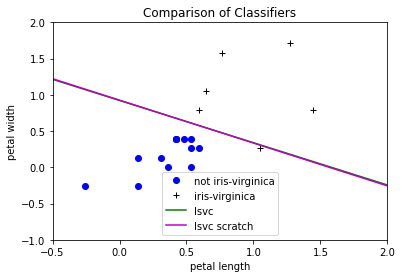

In [8]:
#Plot the data and the decision boundary

#create feature data for plotting
x_dec_bnd = np.linspace(-2,2,100).reshape(-1,1)
#Linear SVC classification boundary from sklearn
y_lsvc_sklearn = (theta_lsvc_sklearn[2] * np.ones((100,1)) + theta_lsvc_sklearn[0] * x_dec_bnd) / -theta_lsvc_sklearn[1]
#Linear SVC classification boundary from scratch
y_scratch = (theta_scratch[2] * np.ones((100,1)) + theta_scratch[0] * x_dec_bnd) / -theta_scratch[1]

y_1 = np.where(y_test==1)[0] #training data, iris-virginica
y_0 = np.where(y_test==0)[0] #training data, not iris-virginica
plt.plot(X_test_scaled[y_0,0],X_test_scaled[y_0,1],'bo',label="not iris-virginica")
plt.plot(X_test_scaled[y_1,0],X_test_scaled[y_1,1],'k+',label="iris-virginica")

plt.plot(x_dec_bnd,y_lsvc_sklearn,'g',label="lsvc")
plt.plot(x_dec_bnd,y_scratch,'m',label="lsvc scratch")
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.title('Comparison of Classifiers')
plt.xlim((-0.5,2))
plt.ylim((-1,2))
plt.legend()